# Weighted Prediction Error

In [1]:
#!pip install soundfile librosa numpy pyroomacoustics matplotlib tqdm torch torchaudio

In [2]:
import soundfile as sf
import librosa
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
from tqdm import tqdm
import requests
import onnxruntime
%matplotlib inline

In [3]:
N_FTT = 512
HOP=128
WIN=512
WINDOW="blackman"
EPS=1e-10
COUNT_OF_FILES = 10

In [4]:
from utils import download_dataset
download_dataset()

Файл уже найден


In [5]:
path_single = Path("./single")
path_single.mkdir(exist_ok=True)

path_reverbed = Path("./single/reverbed")
path_reverbed.mkdir(exist_ok=True)

path_output_mono = Path("./single/output")
path_output_mono.mkdir(exist_ok=True)
print("Созданы директории:single/reverbed, single/output")

Созданы директории:single/reverbed, single/output


In [6]:
current_dir = Path(".")
data = Path("nonblind_test.clean.zip")
with zipfile.ZipFile(data, "r") as zip_ref:
    zip_ref.extractall(current_dir)
print("Архив успешно разархивирован в clean")

Архив успешно разархивирован в clean


In [7]:
from utils import read_normalize, plot_audio_spectrogram
y_clean, sr = read_normalize("clean/fileid_1.flac")
print(y_clean.shape, sr)

(112042,) 16000


## Single channel

In [8]:
def reverb_audio_single(y_clean, sr, plot=False):
    room_dim = [6.0, 4.0, 3]
    rt60 = 0.8
    
    absorption, max_order = pra.inverse_sabine(rt60, room_dim)
    
    room = pra.ShoeBox(
        room_dim, fs=sr,
        materials=pra.Material(absorption),
        max_order=max_order
    )
    
    src_pos = [5.0, 4, 1.7]
    mic_pos = [2.5, 2, 1.6]
    
    if plot:
        fig, ax = room.plot(img_order=0, figsize=(8, 5))
        ax.scatter(src_pos[0], src_pos[1], src_pos[2],
                   color='red', s=400, marker='*')
        ax.scatter(mic_pos[0], mic_pos[1], mic_pos[2],
               color='blue', s=200, marker='^')
        plt.title("Виртуальная комната")
        return None

        
    room.add_source(src_pos, signal=y_clean)
    
    mic = pra.MicrophoneArray(np.c_[mic_pos], room.fs)
    room.add_microphone_array(mic)
    
    room.simulate()
    reverbed = room.mic_array.signals[0]

    if len(reverbed) > len(y_clean):
        reverbed = reverbed[:len(y_clean)]
        
    return reverbed

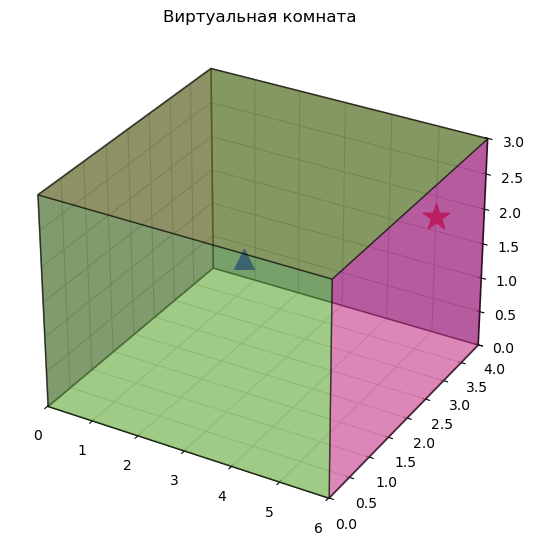

In [9]:
reverb_audio_single(y_clean, sr, plot=True)

In [10]:
y_reverbed = reverb_audio_single(y_clean, sr)
# sf.write(path_reverbed / "test.flac", y_reverbed, sr)

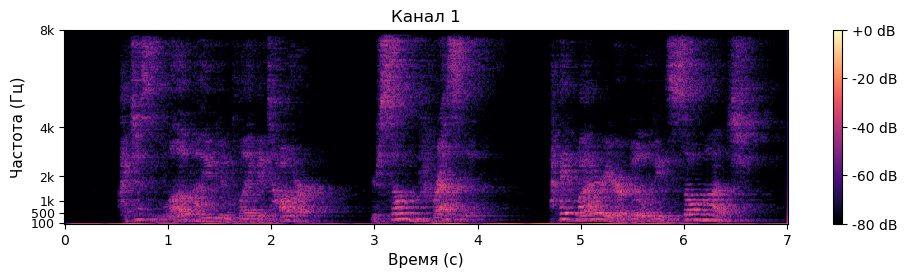

In [11]:
plot_audio_spectrogram(y_reverbed, sr, n_fft=N_FTT, hop_length=HOP, win_length=WIN, window=WINDOW)

In [12]:
def wpe_mono(
    y, sr,
    n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW, eps=EPS,
    D=3, L=10, N=3, reg=1e-6
):
    Y = librosa.stft(y, n_fft=n_fft, hop_length=hop, win_length=win, window=window)
    F, T = Y.shape

    P = np.abs(Y) ** 2
    kernel = np.ones(L, dtype=P.dtype) / L
    P_smooth = np.stack([np.convolve(P[f], kernel, mode='same') for f in range(F)])
    lam = np.maximum(P_smooth, eps)                   # (F, T)

    Z = np.copy(Y)

    for n in range(N):
        for f in range(F):
            t_idx = np.arange(D + L, T)
            Te = t_idx.size

            YL = np.vstack([Y[f, t_idx - D - k] for k in range(1, L + 1)])

            y_t = Y[f, t_idx]
            w = 1.0 / (lam[f, t_idx] ** 2)

            Phi = (YL * w) @ YL.conj().T
            Phi += reg * np.eye(L)

            phi = (YL * w) @ y_t.conj()

            g = np.linalg.solve(Phi, phi)

            Z_f = np.copy(Y[f])
            Z_f[t_idx] = y_t - g.conj().T @ YL
            Z[f] = Z_f

            Pz = np.abs(Z_f) ** 2
            lam[f] = np.maximum(np.convolve(Pz, kernel, mode='same'), eps)

    z = librosa.istft(Z, hop_length=hop, win_length=win, window=window, length=len(y))
    return z


In [13]:
y_wpe = wpe_mono(y_reverbed, sr, D=3, L=10, N=3)

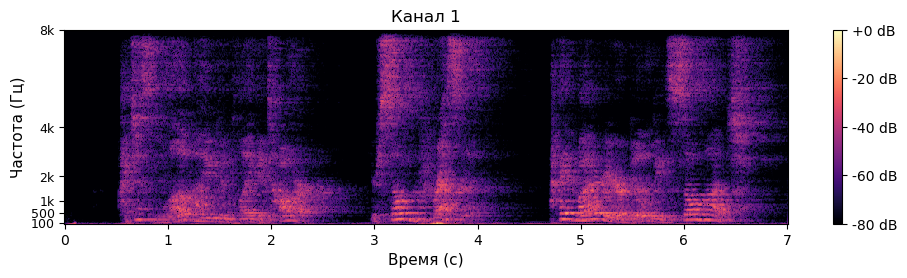

In [14]:
plot_audio_spectrogram(y_wpe, sr, n_fft=N_FTT, hop_length=HOP, win_length=WIN, window=WINDOW)

# Метрики

In [15]:
from metrics import fwsegsnr, cepstral_distance, DNSMOS
print("Для реверберированного:")
print("FWSegSNR:", fwsegsnr(y_clean, y_reverbed, sr, eps=EPS, n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW))
print("CD:", cepstral_distance(y_clean, y_reverbed, sr))
print("DNSMOS:", DNSMOS(y_reverbed, sr))

print("Для очищенного")
print("FWSegSNR:", fwsegsnr(y_clean, y_wpe, sr, eps=EPS, n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW))
print("CD:", cepstral_distance(y_clean, y_wpe, sr))
print("DNSMOS:", DNSMOS(y_wpe, sr))

Для реверберированного:
FWSegSNR: -12.195629968228404
CD: 114.06910400655349
DNSMOS: [[2.6136441 3.3228066 2.432709 ]]
Для очищенного
FWSegSNR: -3.1744182933603597
CD: 116.23092566596372
DNSMOS: [[1.656455  1.5936073 1.3606913]]


In [16]:
y_wpe2 = wpe_mono(y_reverbed, sr, D=3, L=15, N=3)
print("Для L = 15")
print("FWSegSNR:", fwsegsnr(y_clean, y_wpe2, sr, eps=EPS, n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW))
print("CD:", cepstral_distance(y_clean, y_wpe2, sr))
print("DNSMOS:", DNSMOS(y_clean, sr))

Для L = 15
FWSegSNR: -1.0885142640459164
CD: 117.33479470073189
DNSMOS: [[4.016448  4.435159  3.8350701]]


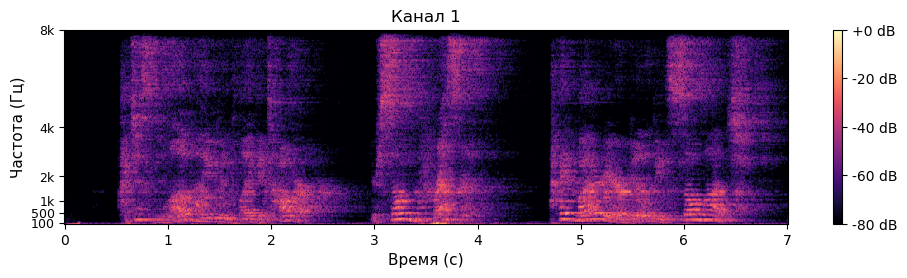

In [17]:
plot_audio_spectrogram(y_wpe2, sr, n_fft=N_FTT, hop_length=HOP, win_length=WIN, window=WINDOW)

### Ревербирируем датасет и применяем WPE

In [18]:
path_clean = Path("clean")

reverbed_fwsegsnr_metric = np.zeros(COUNT_OF_FILES)
reverbed_cd_metric = np.zeros(COUNT_OF_FILES)
reverbed_dnsmos_metric = np.zeros(COUNT_OF_FILES)

fwsegsnr_metric = np.zeros(COUNT_OF_FILES)
cd_metric = np.zeros(COUNT_OF_FILES)
dnsmos_metric = np.zeros(COUNT_OF_FILES)
audio_index = 0

clean_audio = [f for f in path_clean.iterdir() if f.is_file()][0: COUNT_OF_FILES]

for file in clean_audio:
    y_clean, sr = read_normalize(path_clean / file.name)
    y_reverbed = reverb_audio_single(y_clean, sr)
    y_wpe = wpe_mono(y_reverbed, sr, D=3, L=15, N=3)

    reverbed_fwsegsnr_metric[audio_index] = fwsegsnr(y_reverbed, y_wpe, sr, eps=EPS, n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW)
    reverbed_cd_metric[audio_index] = cepstral_distance(y_reverbed, y_wpe, sr)
    reverbed_dnsmos_metric[audio_index] = DNSMOS(y_reverbed, sr)[0, 0]

    fwsegsnr_metric[audio_index] = fwsegsnr(y_clean, y_wpe, sr, eps=EPS, n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW)
    cd_metric[audio_index] = cepstral_distance(y_clean, y_wpe, sr)
    dnsmos_metric[audio_index] = DNSMOS(y_wpe, sr)[0, 0]

    audio_index += 1

    sf.write(path_reverbed / file.name, y_reverbed, sr)
    sf.write(path_output_mono / file.name, y_wpe, sr)

In [19]:
print("FWSegSNR")
print("Clean - Reverbed:", np.mean(fwsegsnr_metric - reverbed_fwsegsnr_metric))
print("Mean:", np.mean(fwsegsnr_metric))
print()
print("Cepstral Distance")
print("Clean - Reverbed:", np.mean(cd_metric - reverbed_cd_metric))
print("Mean:", np.mean(cd_metric))
print()
print("DNSMOS")
print("Clean - Reverbed:", np.mean(dnsmos_metric - reverbed_dnsmos_metric))
print("Mean:", np.mean(dnsmos_metric))

FWSegSNR
Clean - Reverbed: -11.954538740658313
Mean: 0.6718340006172813

Cepstral Distance
Clean - Reverbed: 69.07412040930782
Mean: 93.3508725744644

DNSMOS
Clean - Reverbed: 0.044636738300323484
Mean: 1.9823257327079773


## Multi-channel

In [20]:
path_multiple = Path("./multiple")
path_multiple.mkdir(exist_ok=True)

path_output_multi = Path("./multiple/output")
path_output_multi.mkdir(exist_ok=True)
print("Созданы директории: multiple/output")

Созданы директории: multiple/output


In [33]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt

def reverb_audio_multi(y_clean, sr, plot=False):
    room_dim = [8.0, 6.0, 3.0] 
    rt60 = 0.6

    absorption, max_order = pra.inverse_sabine(rt60, room_dim)

    room = pra.ShoeBox(
        room_dim, fs=sr,
        materials=pra.Material(absorption),
        max_order=max_order
    )

    src_pos = [7.0, 1.0, 1.7]

    mic_center = np.array([2.0, 4.5, 1.6])
    d = 0.5
    num_mics = 5

    mic_positions = np.zeros((3, num_mics))
    for i in range(num_mics):
        mic_positions[:, i] = mic_center + np.array([ \
        d * (i - (num_mics - 1) / 2),
        0.15 * (i - (num_mics - 1) / 2),
        0.0
    ])

    if plot:
        fig, ax = room.plot(img_order=0, figsize=(8, 5))
        ax.scatter(src_pos[0], src_pos[1], src_pos[2],
                   color='red', s=400, marker='*', label='Источник')
        ax.scatter(mic_positions[0, :], mic_positions[1, :], mic_positions[2, :],
                   color='blue', s=200, marker='^', label='Массив микрофонов')
        plt.legend()
        plt.title("Виртуальная комната с 5 микрофонами")
        plt.show()
        return

    room.add_source(src_pos, signal=y_clean)
    room.add_microphone_array(pra.MicrophoneArray(mic_positions, room.fs))

    room.simulate()
    reverbed = room.mic_array.signals

    if len(reverbed) > len(y_clean):
        reverbed = reverbed[:len(y_clean)]
            
    return room.mic_array.signals


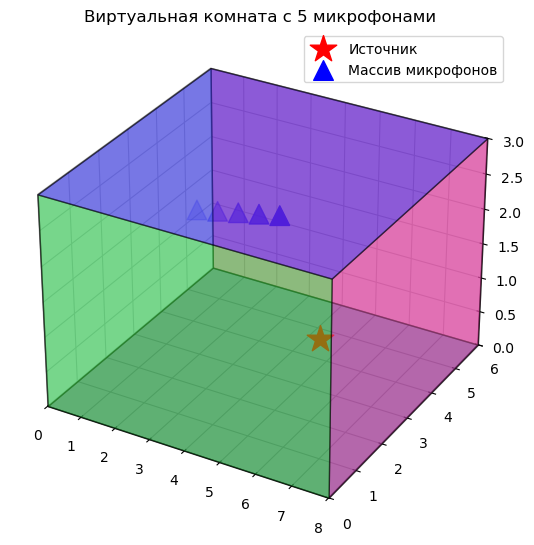

In [34]:
reverb_audio_multi(y_clean, sr, plot=True)

In [35]:
y_reverbed = reverb_audio_multi(y_clean, sr)
# sf.write(path_reverbed / "test.flac", y_reverbed.T, sr)

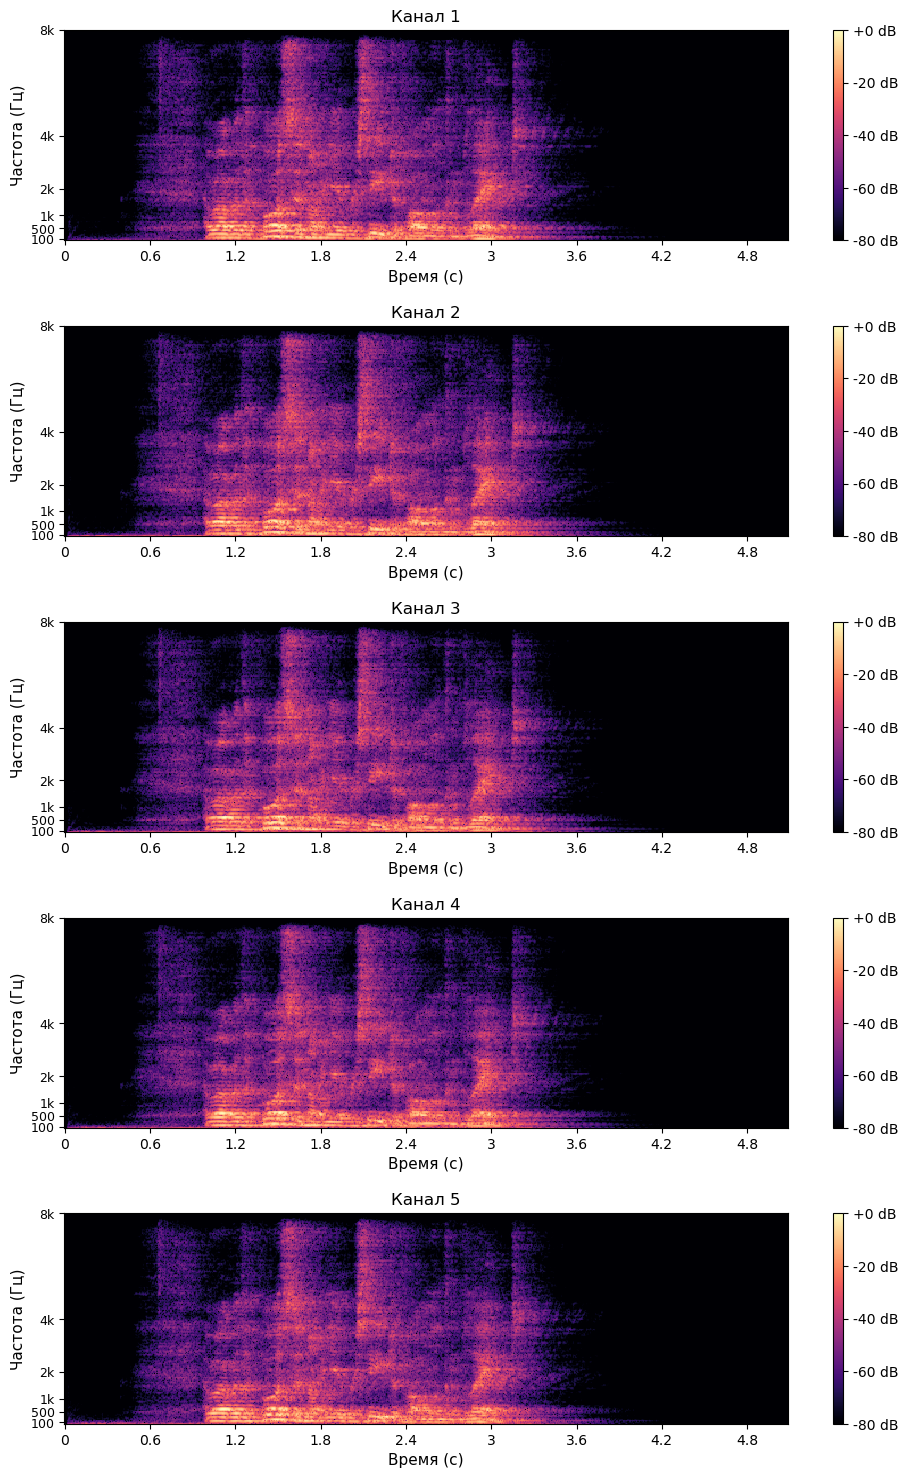

In [36]:
plot_audio_spectrogram(y_reverbed, sr, n_fft=N_FTT, hop_length=HOP, win_length=WIN, window=WINDOW)

In [37]:
def wpe_multi(
    y, sr,
    n_fft=2048, hop=512, win=None, window="hann",
    eps=1e-8, D=3, L=10, N=3, reg=1e-6,
    ref=0, estimate_all=False
):
    if y.ndim == 1:
        raise ValueError("Для многоканальной версии ожидаю y.shape == (M, samples).")

    M = y.shape[0]

    Y = np.stack([
        librosa.stft(y[m], n_fft=n_fft, hop_length=hop, win_length=win, window=window)
        for m in range(M)
    ])
    _, F, T = Y.shape

    Pref = np.abs(Y[ref]) ** 2                      # (F, T)
    kernel = np.ones(L, dtype=Pref.dtype) / L
    P_smooth = np.stack([np.convolve(Pref[f], kernel, mode='same') for f in range(F)])
    lam = np.maximum(P_smooth, eps)                 # (F, T)

    Z = np.copy(Y)

    channels_to_process = range(M) if estimate_all else [ref]

    for m_tgt in channels_to_process:
        for _ in range(N):
            for f in range(F):
                t_idx = np.arange(D + L, T)
                if t_idx.size == 0:
                    continue

                rows = []
                for k in range(1, L + 1):
                    for m in range(M):
                        rows.append(Y[m, f, t_idx - D - k])
                YL = np.vstack(rows)

                y_t = Y[m_tgt, f, t_idx]

                w = 1.0 / (lam[f, t_idx] ** 2)

                Phi = (YL * w) @ YL.conj().T
                Phi += reg * np.eye(M * L)
                phi = (YL * w) @ y_t.conj() 

                g = np.linalg.solve(Phi, phi)

                z_f = np.copy(Z[m_tgt, f])
                z_f[t_idx] = y_t - g.conj().T @ YL
                Z[m_tgt, f] = z_f

                Pz = np.abs(z_f) ** 2
                lam[f] = np.maximum(np.convolve(Pz, kernel, mode='same'), eps)

    z_time = np.stack([
        librosa.istft(Z[m], hop_length=hop, win_length=win, window=window, length=y.shape[1])
        for m in range(M)
    ])
    return z_time

In [38]:
def merge_channels(y, sr):
    mono = y[0]
    return mono


In [39]:
y_wpe = merge_channels(wpe_multi(y_reverbed, sr, D=3, L=15, N=3), sr)

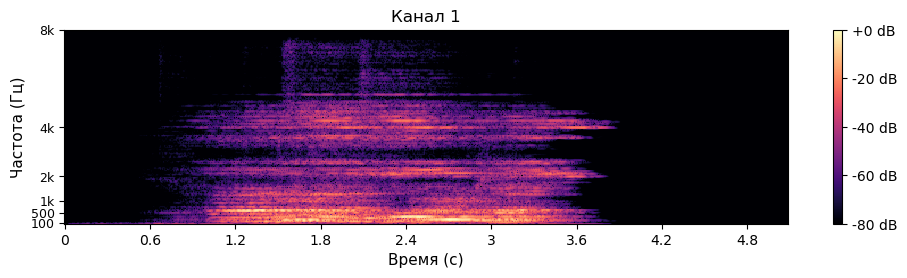

In [40]:
plot_audio_spectrogram(y_wpe, sr, n_fft=N_FTT, hop_length=HOP, win_length=WIN, window=WINDOW)

In [41]:
sf.write(path_output_multi / "test.flac", y_wpe.T, sr)

In [42]:
print("Для очищенного")
print("FWSegSNR:", fwsegsnr(y_clean, y_wpe, sr, eps=EPS, n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW))
print("CD:", cepstral_distance(y_clean, y_wpe, sr))
print("DNSMOS:", DNSMOS(y_wpe, sr))

Для очищенного
FWSegSNR: -6.139540150483075
CD: 128.60583138613572
DNSMOS: [[2.0281858 2.6828687 1.7308781]]


In [43]:
path_clean = Path("clean")

reverbed_fwsegsnr_metric = np.zeros(COUNT_OF_FILES)
reverbed_cd_metric = np.zeros(COUNT_OF_FILES)
reverbed_dnsmos_metric = np.zeros(COUNT_OF_FILES)

fwsegsnr_metric = np.zeros(COUNT_OF_FILES)
cd_metric = np.zeros(COUNT_OF_FILES)
dnsmos_metric = np.zeros(COUNT_OF_FILES)
audio_index = 0

clean_audio = [f for f in path_clean.iterdir() if f.is_file()][0: COUNT_OF_FILES]

for file in clean_audio:
    y_clean, sr = read_normalize(path_clean / file.name)
    y_reverbed = reverb_audio_multi(y_clean, sr)
    y_wpe = merge_channels(wpe_multi(y_reverbed, sr, D=3, L=15, N=3), sr)

    fwsegsnr_metric[audio_index] = fwsegsnr(y_clean, y_wpe, sr, eps=EPS, n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW)
    cd_metric[audio_index] = cepstral_distance(y_clean, y_wpe, sr)
    dnsmos_metric[audio_index] = DNSMOS(y_wpe, sr)[0, 0]
    audio_index += 1
    
    sf.write(path_output_multi / file.name, y_wpe, sr)

In [44]:
print("FWSegSNR")
print("Clean - Reverbed:", np.mean(fwsegsnr_metric - reverbed_fwsegsnr_metric))
print("Mean:", np.mean(fwsegsnr_metric))
print()
print("Cepstral Distance")
print("Clean - Reverbed:", np.mean(cd_metric - reverbed_cd_metric))
print("Mean:", np.mean(cd_metric))
print()
print("DNSMOS")
print("Clean - Reverbed:", np.mean(dnsmos_metric - reverbed_dnsmos_metric))
print("Mean:", np.mean(dnsmos_metric))

FWSegSNR
Clean - Reverbed: -3.740733714647228
Mean: -3.740733714647228

Cepstral Distance
Clean - Reverbed: 126.01942158870762
Mean: 126.01942158870762

DNSMOS
Clean - Reverbed: 2.1485206127166747
Mean: 2.1485206127166747
